In [1]:
# Import Libraries
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import shap
import joblib

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create directories
os.makedirs('../models', exist_ok=True)
os.makedirs('../results', exist_ok=True)

print("Libraries imported and directories created successfully!")

Libraries imported and directories created successfully!


In [3]:
# Load Data
df = pd.read_csv(r'C:/Users/admin/insurance-risk-analysis-week3/data/raw/insurance_data.csv')
print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nData Types:\n{df.dtypes.value_counts()}")

# Basic statistics
print("\nBasic Statistics:")
print(f"Total Premium: R{df['TotalPremium'].sum():,.2f}")
print(f"Total Claims: R{df['TotalClaims'].sum():,.2f}")
print(f"Overall Loss Ratio: {(df['TotalClaims'].sum() / df['TotalPremium'].sum()):.4f}")
print(f"Policies with Claims: {df[df['TotalClaims'] > 0].shape[0]} ({(df[df['TotalClaims'] > 0].shape[0] / len(df) * 100):.2f}%)")


Data loaded: 5000 rows, 18 columns

Data Types:
object     9
float64    7
int64      2
Name: count, dtype: int64

Basic Statistics:
Total Premium: R33,526,782.33
Total Claims: R3,123,652.22
Overall Loss Ratio: 0.0932
Policies with Claims: 1479 (29.58%)


In [4]:
# Part 1: Data Preparation
def prepare_data(df, target_column, exclude_columns=None):
    """Prepare data for modeling."""
    data = df.copy()
    
    if 'has_claim' not in data.columns:
        data['has_claim'] = (data['TotalClaims'] > 0).astype(int)
    
    # Feature engineering
    if 'RegistrationYear' in data.columns:
        data['vehicle_age'] = 2024 - data['RegistrationYear']
        data['vehicle_age'] = data['vehicle_age'].clip(0, 50)
    
    if 'SumInsured' in data.columns and 'TotalPremium' in data.columns:
        data['premium_to_sum_insured'] = data['TotalPremium'] / (data['SumInsured'] + 1)
    
    if 'CustomValueEstimate' in data.columns and 'SumInsured' in data.columns:
        data['value_estimate_ratio'] = data['CustomValueEstimate'] / (data['SumInsured'] + 1)
    
    if 'TotalPremium' in data.columns and 'TotalClaims' in data.columns:
        data['expected_loss_ratio'] = data['TotalClaims'] / (data['TotalPremium'] + 1)
    
    if 'vehicle_age' in data.columns and 'TotalPremium' in data.columns:
        data['age_premium_interaction'] = data['vehicle_age'] * data['TotalPremium']
    
    if exclude_columns is None:
        exclude_columns = ['PolicyID', 'TransactionMonth', target_column]
    else:
        exclude_columns = exclude_columns + [target_column]
    
    feature_columns = [col for col in data.columns if col not in exclude_columns]
    X = data[feature_columns].copy()
    y = data[target_column]
    
    print(f"Selected {len(feature_columns)} features: {feature_columns}")
    
    return X, y, feature_columns

def preprocess_data(X, y, test_size=0.2, random_state=42):
    """Preprocess data: handle missing values, encode categorical variables, scale."""
    categorical_cols = X.select_dtypes(include=['object']).columns
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    
    # Handle missing values
    if len(numerical_cols) > 0:
        num_imputer = SimpleImputer(strategy='median')
        X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])
    
    if len(categorical_cols) > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])
    
    # Encode categorical
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
    
    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_processed = pd.DataFrame(X_scaled, columns=X.columns)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y, test_size=test_size, random_state=random_state
    )
    
    print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, scaler, label_encoders

In [5]:
# Part 2: Claim Severity Prediction

severity_df = df[df['TotalClaims'] > 0].copy()
print(f"\nSeverity dataset (policies with claims): {severity_df.shape[0]} policies")
print(f"Average claim amount: R{severity_df['TotalClaims'].mean():.2f}")

X_sev, y_sev, sev_features = prepare_data(
    severity_df,
    target_column='TotalClaims',
    exclude_columns=['PolicyID','TransactionMonth','has_claim','claim_frequency','claim_severity','margin','loss_ratio']
)
X_train_sev, X_test_sev, y_train_sev, y_test_sev, scaler_sev, label_encoders_sev = preprocess_data(X_sev, y_sev)

# Models
severity_models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

results_severity = {}
for name, model in severity_models.items():
    model.fit(X_train_sev, y_train_sev)
    y_pred_train = model.predict(X_train_sev)
    y_pred_test = model.predict(X_test_sev)
    
    results_severity[name] = {
        'model': model,
        'RMSE_train': np.sqrt(mean_squared_error(y_train_sev, y_pred_train)),
        'RMSE_test': np.sqrt(mean_squared_error(y_test_sev, y_pred_test)),
        'R2_train': r2_score(y_train_sev, y_pred_train),
        'R2_test': r2_score(y_test_sev, y_pred_test),
        'MAE_train': mean_absolute_error(y_train_sev, y_pred_train),
        'MAE_test': mean_absolute_error(y_test_sev, y_pred_test),
        'y_pred_test': y_pred_test
    }

severity_comparison = pd.DataFrame([{
    'Model': name,
    'Test_RMSE': metrics['RMSE_test'],
    'Test_R2': metrics['R2_test'],
    'Test_MAE': metrics['MAE_test'],
    'Train_R2': metrics['R2_train']
} for name, metrics in results_severity.items()]).sort_values('Test_R2', ascending=False)

best_severity_model_name = severity_comparison.iloc[0]['Model']
best_severity_model = results_severity[best_severity_model_name]['model']
joblib.dump(best_severity_model, '../models/best_severity_model.pkl')


Severity dataset (policies with claims): 1479 policies
Average claim amount: R2112.00
Selected 20 features: ['Province', 'VehicleType', 'Gender', 'Make', 'Model', 'TotalPremium', 'CustomValueEstimate', 'SumInsured', 'CalculatedPremiumPerTerm', 'CoverType', 'RegistrationYear', 'NumberOfDoors', 'Bodytype', 'MaritalStatus', 'LossRatio', 'vehicle_age', 'premium_to_sum_insured', 'value_estimate_ratio', 'expected_loss_ratio', 'age_premium_interaction']
Training set: (1183, 20), Test set: (296, 20)


['../models/best_severity_model.pkl']

In [6]:

# Part 3: Premium Prediction
X_prem, y_prem, prem_features = prepare_data(
    df,
    target_column='TotalPremium',
    exclude_columns=['PolicyID','TransactionMonth','has_claim','claim_frequency','claim_severity','margin','loss_ratio']
)
X_train_prem, X_test_prem, y_train_prem, y_test_prem, scaler_prem, label_encoders_prem = preprocess_data(X_prem, y_prem)

premium_models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

results_premium = {}
for name, model in premium_models.items():
    model.fit(X_train_prem, y_train_prem)
    y_pred_test = model.predict(X_test_prem)
    
    percentage_error = np.mean(np.abs((y_test_prem - y_pred_test)/y_test_prem))*100
    
    results_premium[name] = {
        'model': model,
        'RMSE_test': np.sqrt(mean_squared_error(y_test_prem, y_pred_test)),
        'R2_test': r2_score(y_test_prem, y_pred_test),
        'MAE_test': mean_absolute_error(y_test_prem, y_pred_test),
        'Percentage_Error': percentage_error
    }

premium_comparison = pd.DataFrame([{
    'Model': name,
    'Test_RMSE': metrics['RMSE_test'],
    'Test_R2': metrics['R2_test'],
    'Test_MAE': metrics['MAE_test'],
    'Percentage_Error': metrics['Percentage_Error']
} for name, metrics in results_premium.items()]).sort_values('Test_R2', ascending=False)

best_premium_model_name = premium_comparison.iloc[0]['Model']
best_premium_model = results_premium[best_premium_model_name]['model']
joblib.dump(best_premium_model, '../models/best_premium_model.pkl')

Selected 20 features: ['Province', 'VehicleType', 'Gender', 'Make', 'Model', 'TotalClaims', 'CustomValueEstimate', 'SumInsured', 'CalculatedPremiumPerTerm', 'CoverType', 'RegistrationYear', 'NumberOfDoors', 'Bodytype', 'MaritalStatus', 'LossRatio', 'vehicle_age', 'premium_to_sum_insured', 'value_estimate_ratio', 'expected_loss_ratio', 'age_premium_interaction']
Training set: (4000, 20), Test set: (1000, 20)


['../models/best_premium_model.pkl']

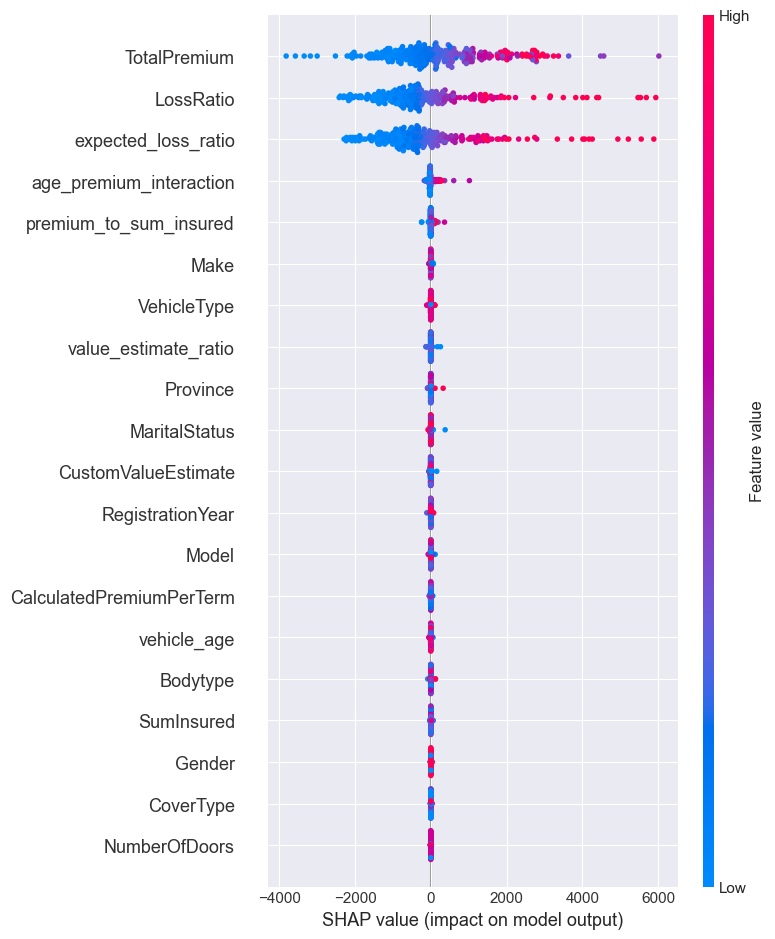

In [7]:
# Part 4: Feature Importance Analysis

if hasattr(best_severity_model, 'feature_importances_'):
    importances = best_severity_model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': sev_features, 'Importance': importances}).sort_values('Importance', ascending=False)
    feature_importance_df.head(10)

# SHAP analysis
try:
    explainer = shap.TreeExplainer(best_severity_model)
    shap_values = explainer(X_test_sev)
    shap.summary_plot(shap_values, X_test_sev)
except Exception as e:
    print(f"SHAP analysis failed: {e}")

In [10]:
df.columns

Index(['PolicyID', 'TransactionMonth', 'Province', 'VehicleType', 'Gender',
       'Make', 'Model', 'TotalPremium', 'TotalClaims', 'CustomValueEstimate',
       'SumInsured', 'CalculatedPremiumPerTerm', 'CoverType',
       'RegistrationYear', 'NumberOfDoors', 'Bodytype', 'MaritalStatus',
       'LossRatio'],
      dtype='object')

In [11]:

# Part 5: Risk-Based Pricing Framework
df['has_claim'] = (df['TotalClaims'] > 0).astype(int)
avg_claim_freq = df['has_claim'].mean()
avg_severity = df[df['TotalClaims']>0]['TotalClaims'].mean()
avg_premium = df['TotalPremium'].mean()

expense_loading = 0.20
profit_margin = 0.10
base_risk_premium = avg_claim_freq * avg_severity

risk_multipliers = {'Low Risk':0.7, 'Medium Risk':1.0, 'High Risk':1.5}
pricing_table = []
for seg, mult in risk_multipliers.items():
    risk_premium = base_risk_premium * mult
    pricing_table.append({
        'Risk Segment': seg,
        'Recommended Premium': risk_premium*(1+expense_loading+profit_margin),
        'Current Avg Premium': avg_premium*mult
    })

pricing_df = pd.DataFrame(pricing_table)
pricing_df.to_csv('../results/risk_based_pricing_framework.csv', index=False)
print(pricing_df)


  Risk Segment  Recommended Premium  Current Avg Premium
0     Low Risk           568.504704          4693.749526
1  Medium Risk           812.149578          6705.356466
2    High Risk          1218.224367         10058.034698


In [12]:

# Part 6: Evaluation Summary
print("Best Severity Model:", best_severity_model_name)
print("Best Premium Model:", best_premium_model_name)


Best Severity Model: Random Forest
Best Premium Model: XGBoost
